In [50]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pylab
from Bio import SeqIO
from Bio import Phylo
from ete3 import Tree, NodeStyle, TreeStyle, faces, ClusterTree, AttrFace, ProfileFace, TextFace, CircleFace
import pandas as pd
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib.backends.backend_pdf import PdfPages
from PyQt4 import QtCore
from PyQt4.QtGui import QGraphicsRectItem, QGraphicsSimpleTextItem, \
    QGraphicsEllipseItem, QColor, QPen, QBrush
import colorsys
import random
%matplotlib inline

In [2]:
def checkSlash(directory):
    if directory[-1] != '/':
        directory = directory + '/'
    return directory

def importMapping(inFile):
    mapping = {}
    with open(inFile, 'r') as f:
        for line in f:
            if '#' == line[0]:
                continue
            line = line.strip().split('\t')
            mapping[line[0]] = line[2]
    return mapping

def editNexus(inFile, outFile):
    outF = open(outFile, 'w')
    with open(inFile, 'r') as f:
        for line in f:
            if 'color=' in line:
                line = line.split('[')[0] + '\n'
            elif line == 'end\n':
                line = 'end;'
            elif ';end;' in line:
                line = line.replace(';end;', ';\nend;')
            elif 'figtree' in line:
                break
            outF.write(line)
    outF.close()

In [3]:
oldPath = '/Users/sarahspencer/Dropbox/2017_05_Pseudo_Spence/subgroupB/tree_counting/'
newPath = 'subgroupB/'
if not os.path.exists(newPath):
    os.makedirs(newPath)
treeFile = '1_2_177683.tree'
outTree = newPath + treeFile
editNexus(oldPath + treeFile, outTree)

#Edit to export newick format for ete toolkit
outNewick = outTree.replace('.tree', '.nhx')
Phylo.convert(outTree, 'nexus', outNewick, 'newick')
mapping = importMapping('map_v2.txt')

{'MPBD7': '#4c72b0', 'FW300': '#4e7ca3', 'FW507': '#4f8695', 'GW531': '#519187', 'FW303': '#539b79', 'GW456': '#55a66b', 'DP16D': '#669a65', 'GW458': '#7a8a61', 'GW460': '#90785c', 'GW123': '#a66758', 'FW104': '#bb5554', 'GP01': '#bc525d', 'MPBC4': '#af5970', 'GW247': '#a26083', 'FW305': '#966794', 'FW215': '#896ea7', 'FW216': '#8778ad', 'FW602': '#9685a1', 'FW301': '#a49395', 'MPBD4': '#b3a189', 'FW510': '#c0ae7e', 'FW126': '#c8b977', 'GW704': '#b4b889', 'MPR': '#9fb79a', 'FW306': '#8bb6ac', 'NA': '#76b6bd', 'GW101': '#64b5cd'}


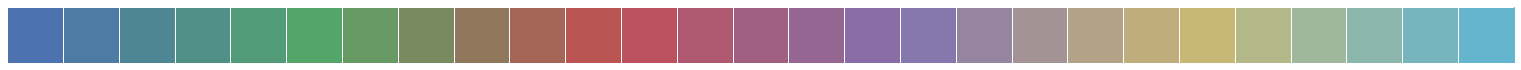

In [23]:
#Prepare an iTol descriptive file for source well
#Map well to color
metaFile = open('map_v2.txt', 'r')
colorDict = {}
for line in metaFile:
    if '#' not in line:
        line = line.strip().split('\t')
        wellID = line[2].split('-')[0]
        if wellID not in colorDict:
            colorDict[wellID] = ''
metaFile.close()
numColors = len(colorDict)
cmap = sns.color_palette('deep')
paletteList = []
for i,p in enumerate(cmap.as_hex()):
    paletteList.append(p)
cmap2 = sns.blend_palette(paletteList, numColors)
sns.set_palette(cmap2, n_colors=numColors)
sns.palplot(cmap2)
for i,p in enumerate(cmap2.as_hex()):
    wellID = list(colorDict.keys())[i]
    colorDict[wellID] = p
print(colorDict)

In [31]:
class InteractiveItem(QGraphicsRectItem):
    def __init__(self, *arg, **karg):
        QGraphicsRectItem.__init__(self, *arg, **karg)
        self.node = None
        self.label = None
        self.setCursor(QtCore.Qt.PointingHandCursor)
        self.setAcceptsHoverEvents(True)

    def hoverEnterEvent (self, e):
        # There are many ways of adding interactive elements. With the
        # following code, I show/hide a text item over my custom
        # DynamicItemFace
        if not self.label:
            self.label = QGraphicsRectItem()
            self.label.setParentItem(self)
            # This is to ensure that the label is rendered over the
            # rest of item children (default ZValue for items is 0)
            self.label.setZValue(1)
            self.label.setBrush(QBrush(QColor("white")))
            self.label.text = QGraphicsSimpleTextItem()
            self.label.text.setParentItem(self.label)

        self.label.text.setText(self.node.name)
        self.label.setRect(self.label.text.boundingRect())
        self.label.setVisible(True)

    def hoverLeaveEvent(self, e):
        if self.label:
            self.label.setVisible(False)

def random_color(h=None):
    """Generates a random color in RGB format."""
    if not h:
        h = random.random()
    s = 0.5
    l = 0.5
    return _hls2hex(h, l, s)

def _hls2hex(h, l, s):
    return '#%02x%02x%02x' %tuple(map(lambda x: int(x*255),
                                      colorsys.hls_to_rgb(h, l, s)))

def ugly_name_face(node, *args, **kargs):
    """ This is my item generator. It must receive a node object, and
    returns a Qt4 graphics item that can be used as a node face.
    """

    # receive an arbitrary number of arguments, in this case width and
    # height of the faces
    width = args[0][0]
    height = args[0][1]

    ## Creates a main master Item that will contain all other elements
    ## Items can be standard QGraphicsItem
    # masterItem = QGraphicsRectItem(0, 0, width, height)

    # Or your custom Items, in which you can re-implement interactive
    # functions, etc. Check QGraphicsItem doc for details.
    masterItem = InteractiveItem(0, 0, width, height)

    # Keep a link within the item to access node info
    masterItem.node = node

    # I dont want a border around the masterItem
    masterItem.setPen(QPen(QtCore.Qt.NoPen))

    # Add ellipse around text
    ellipse = QGraphicsEllipseItem(masterItem.rect())
    ellipse.setParentItem(masterItem)
    # Change ellipse color
    ellipse.setBrush(QBrush(QColor( random_color())))

    # Add node name within the ellipse
    text = QGraphicsSimpleTextItem(node.name)
    text.setParentItem(ellipse)
    text.setPen(QPen(QPen(QColor("white"))))

    # Center text according to masterItem size
    tw = text.boundingRect().width()
    th = text.boundingRect().height()
    center = masterItem.boundingRect().center()
    text.setPos(center.x()-tw/2, center.y()-th/2)

    return masterItem

def master_ly(node):
    if node.is_leaf():
        # Create an ItemFAce. First argument must be the pointer to
        # the constructor function that returns a QGraphicsItem. It
        # will be used to draw the Face. Next arguments are arbitrary,
        # and they will be forwarded to the constructor Face function.
        F = faces.DynamicItemFace(ugly_name_face, 100, 50)
        faces.add_face_to_node(F, node, 0, position="aligned")

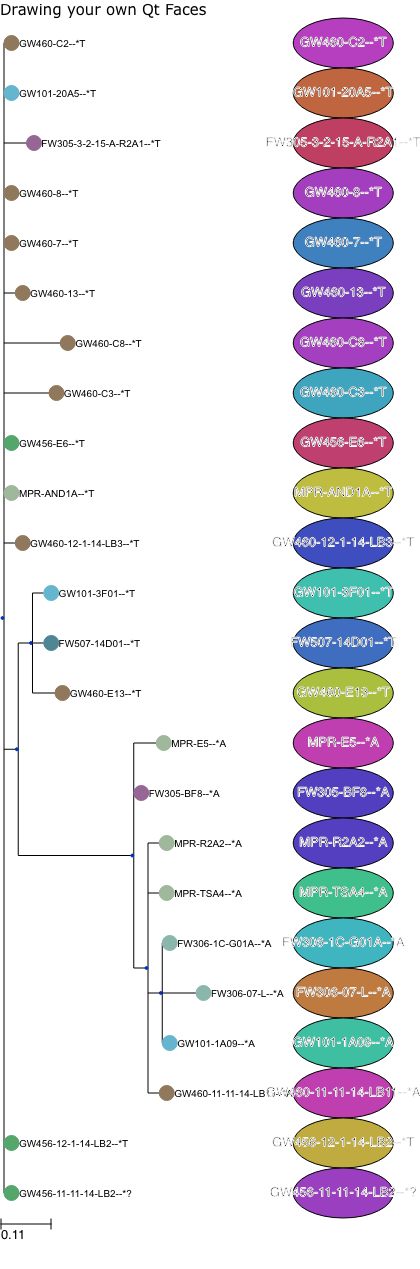

In [33]:
tree = Tree(outNewick)

for leaf in tree:
    leaf.name = mapping[leaf.name.split('--')[0]] + '--' + leaf.name.split('--')[1]
    wellName = leaf.name.split('-')[0]
    nstyle = NodeStyle()
    thisColor = colorDict[wellName]
    nstyle["fgcolor"] = thisColor
    nstyle["size"] = 15
    leaf.set_style(nstyle)

ts = TreeStyle()
ts.layout_fn = master_ly
ts.title.add_face(faces.TextFace("Drawing your own Qt Faces", fsize=15), 0)

tree.render("%%inline", tree_style=ts)

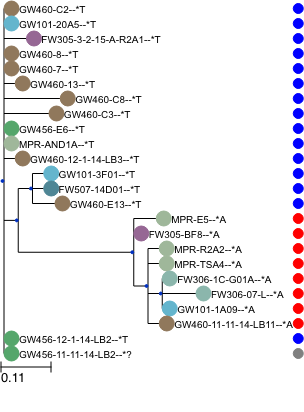

In [49]:


tree = Tree(outNewick)

for leaf in tree:
    leaf.name = mapping[leaf.name.split('--')[0]] + '--' + leaf.name.split('--')[1]
    wellName = leaf.name.split('-')[0]
    nstyle = NodeStyle()
    thisColor = colorDict[wellName]
    nstyle["fgcolor"] = thisColor
    nstyle["size"] = 15
    leaf.set_style(nstyle)

for leaf in tree:
    if '--*T' in leaf.name:
        leaf.add_face(CircleFace(5, 'blue', style='circle'), 0, position='aligned')
    elif '--*A' in leaf.name:
        leaf.add_face(CircleFace(5, 'red', style='circle'), 0, position='aligned')
    elif '--*G' in leaf.name:
        leaf.add_face(CircleFace(5, 'green', style='circle'), 0, position='aligned')
    elif '--*C' in leaf.name:
        leaf.add_face(CircleFace(5, 'yellow', style='circle'), 0, position='aligned')
    else:
        leaf.add_face(CircleFace(5, 'grey', style='circle'), 0, position='aligned')

tree.render("%%inline")

In [ ]:
#clade.color = branch color
#tree.root_at_midpoint()
tree = Phylo.read(outTree, 'nexus')

for t in tree.get_terminals():
    t.name = t.name.replace(t.name.split('--')[0], mapping[t.name.split('--')[0]])
    #t.name = t.name.replace()

Phylo.draw(tree)